In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
n_landmarks = 10
n_bins = 10

In [ ]:
# sort landmarks by first PCA component
# sort data by label, landmark, first PCA component
# move M[M[np.arange(d), np.argmax(M != 0, axis=1)] < 0] *= -1 to animation

from sklearn.cluster import KMeans
from scipy.optimize import bracket, minimize_scalar

def generate_landmarks(X, n_landmarks, method='kmeans'):
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=n_landmarks)
        kmeans.fit(X)
        return kmeans.cluster_centers_
    elif method == 'random':
        return X[np.random.choice(X.shape[0], size=n_landmarks, replace=False)]

def negative_kernel_entropy(sigma2, squared_distances, n_bins=10):
    K = np.exp(-squared_distances / (2 * sigma2))
    H, _ = np.histogram(K, bins=n_bins, range=(0, 1))
    H = H / H.sum()
    return np.sum(H * np.log(H + 1e-10))

def maximize_kernel_entropy(squared_distances, n_bins=10):
    fun = partial(negative_kernel_entropy, squared_distances=squared_distances, n_bins=n_bins)
    xa_0 = 1e-10
    xb_0 = np.mean(squared_distances)
    
    try:
        xa, xb, xc, _, _, _, funcalls = bracket(fun, xa_0, xb_0)
    except:
        print("Failed to bracket local maximum.")
    else:
        result = minimize_scalar(fun, bracket=(xa, xb, xc))
        if result.success:
            funcalls += result.nfev
            return result.x, -result.fun, funcalls
        else:
            print("Optimization failed.")

    print("Setting sigma2 to the mean squared distance.")
    sigma2 = xb_0
    kernel_entropy = -negative_kernel_entropy(sigma2, squared_distances, n_bins)
    return sigma2, kernel_entropy, None

def pairwise_squared_distance(X, L=None):
    if L is None:
        P = X.T @ X
        return P.diagonal().reshape(-1, 1) + P.diagonal().reshape(1, -1) - 2 * P
    else:
        return np.sum(X ** 2, axis=1).reshape(-1, 1) + np.sum(L ** 2, axis=1).reshape(1, -1) - 2 * X @ L.T

def closest_landmark(X, L):
    D = pairwise_squared_distance(X, L)
    return np.argmin(D, axis=1)

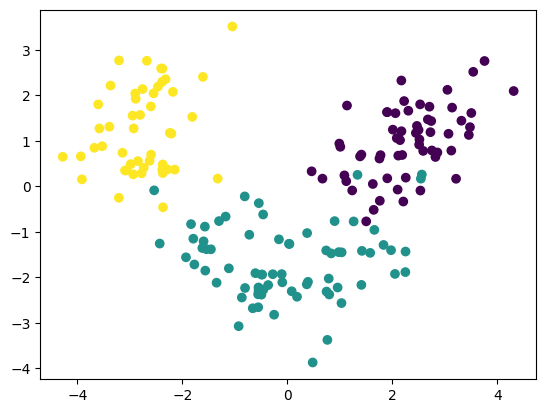

In [4]:
data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

indx = np.argsort(Y_original)
X_original = X_original[indx]
Y_original = Y_original[indx]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y_original)

In [ ]:
P = X_scaled @ X_scaled.T
D = np.diag(P).reshape(-1, 1) + np.diag(P).reshape(1, -1) - 2 * P

plt.imshow(D, cmap='gray')

In [ ]:
def negative_kernel_entropy(sigma2, squared_distances, n_bins=10):
    K = np.exp(-squared_distances / (2 * sigma2))
    H, _ = np.histogram(K, bins=n_bins, range=(0, 1))
    H = H / H.sum()
    return np.sum(H * np.log(H + 1e-10))

def maximize_kernel_entropy(squared_distances, n_bins=10):
    fun = partial(negative_kernel_entropy, squared_distances=squared_distances, n_bins=n_bins)
    xa_0 = 1e-10
    xb_0 = np.mean(squared_distances)
    
    try:
        xa, xb, xc, _, _, _, funcalls = bracket(fun, xa_0, xb_0)
    except:
        print("Failed to bracket local maximum.")
    else:
        result = minimize_scalar(fun, bracket=(xa, xb, xc))
        if result.success:
            funcalls += result.nfev
            return result.x, -result.fun, funcalls
        else:
            print("Optimization failed.")

    print("Setting sigma2 to the mean squared distance.")
    sigma2 = xb_0
    kernel_entropy = -negative_kernel_entropy(sigma2, squared_distances, n_bins)
    return sigma2, kernel_entropy, None

In [ ]:
n_bins = 10
sigma2, kernel_entropy, funcalls = maximize_kernel_entropy(D, n_bins=n_bins)

x = np.linspace(1e-10, 100, 100)
y = [negative_kernel_entropy(sigma2, D, n_bins=n_bins) for sigma2 in x]

xa_0 = 1e-10
xb_0 = np.mean(D)
fun = partial(negative_kernel_entropy, squared_distances=D, n_bins=n_bins)
xa, xb, xc, fa, fb, fc, _ = bracket(fun, xa_0, xb_0)

plt.plot(x, y, "-k")
plt.axvline(x=xa_0, color="k", linestyle="--")
plt.axvline(x=xb_0, color="k", linestyle="--")
plt.plot(xa, fa, "bo")
plt.plot(xb, fb, "ro")
plt.plot(xc, fc, "bo")
plt.plot(sigma2, -kernel_entropy, 'rx')
print(xa_0, xb_0, xa, xb, xc, sigma2, kernel_entropy, funcalls)